In [29]:
import config as cfg
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx

In [30]:
merged = gpd.read_file(cfg.INCOME_DATA / 'geometries_and_income.geojson') 
distritos = pd.read_csv(cfg.ZONIFICACION_DATA / 'distritos/PROCESSED_nombres_distritos.csv')
all_viajes = pd.read_csv(cfg.VIAJES_DATA / 'all_viajes_month_0322.csv')
filtered_viajes = all_viajes.loc[(all_viajes['actividad_origen'] == 'casa')]
population = pd.read_csv('raw/poblacion_distritos_enero_21.csv', sep=';') # SOURCE: https://www.madrid.es/portales/munimadrid/es/Inicio/El-Ayuntamiento/Estadistica/?vgnextfmt=default&vgnextchannel=8156e39873674210VgnVCM1000000b205a0aRCRD

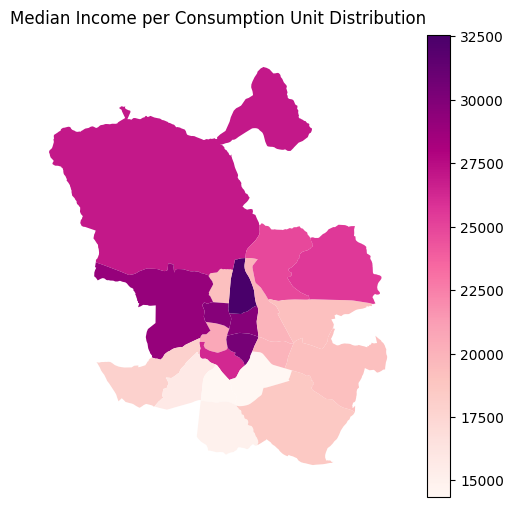

In [7]:
fig, ax = plt.subplots(1, figsize=(6, 6))
merged.plot(
        column='Median income per consumption unit',  # Column containing the LISA values
        cmap='RdPu',        # Use the RdPu colormap
        legend=True,            # Show legend
        ax=ax                   # Axis to plot on
    )
    
    # Set the title with global statistics
ax.set_title('Median Income per Consumption Unit Distribution'
    )

    # Remove axis labels
ax.set_axis_off()

## The City of Madrid

In [23]:
gdf_with_names = merged.merge(distritos[['ID', 'name_2']], on='ID')
gdf_with_names = gdf_with_names[['ID', 'geometry', 'name_2']]
gdf_with_names['ID'] = gdf_with_names['ID'].astype(str).str[-2:]
gdf_with_names = gdf_with_names.to_crs(epsg=3857)

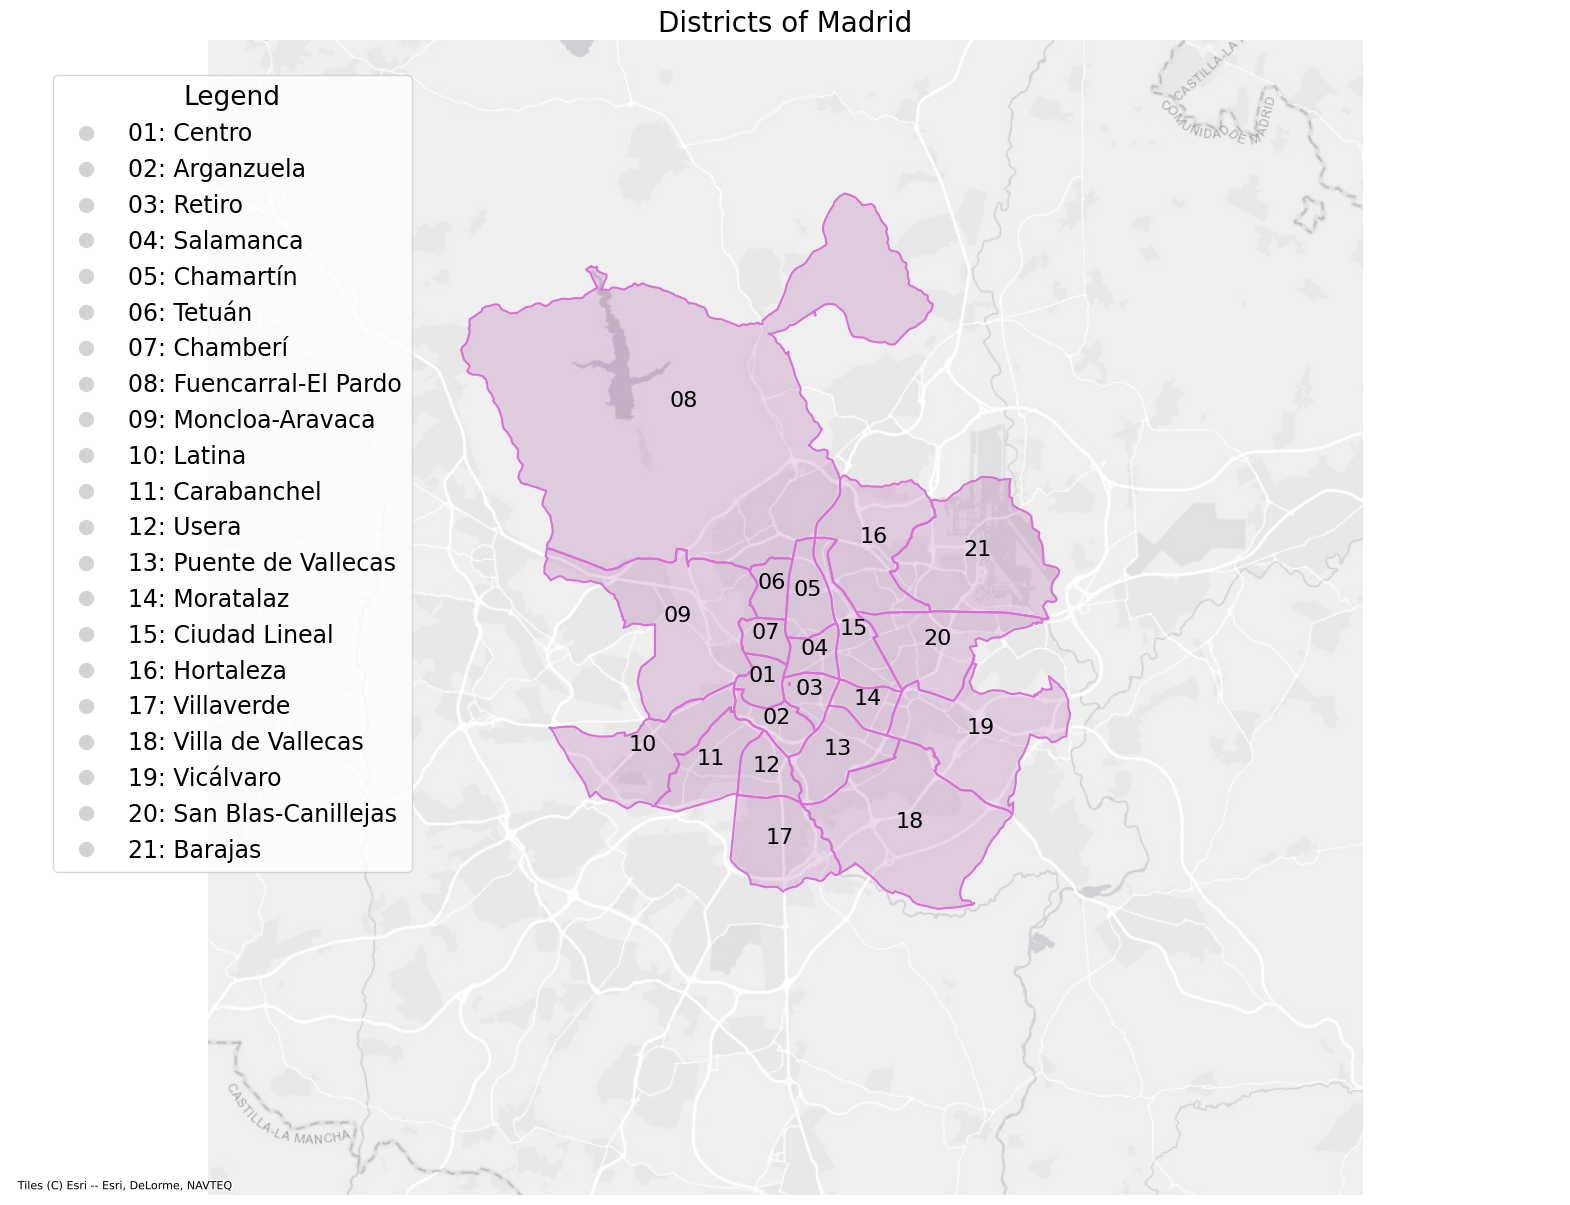

In [44]:
ax = gdf_with_names.plot(figsize=(20,15), color="purple", alpha=0.15)
gdf_with_names.boundary.plot(color="#DA70D6", ax=ax)

ctx.add_basemap(ax,
               crs=gdf_with_names.crs.to_string(),
               source=ctx.providers.Esri.WorldGrayCanvas
              )

bounds = gdf_with_names.total_bounds
ax.set_xlim(bounds[0], bounds[2])  # Set x-axis (longitude)
ax.set_ylim(bounds[1], bounds[3])  # Set y-axis (latitude)

texts = []

# Add district names as annotations
for x, y, label in zip(gdf_with_names.geometry.centroid.x, 
                       gdf_with_names.geometry.centroid.y, 
                       gdf_with_names['ID']):
    texts.append(ax.text(x, y, label, fontsize=16, ha='center', color='black'))  # Change color of text to red

from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"{num}: {name}",
                          markerfacecolor='lightgray', markersize=12)
                   for num, name in zip(gdf_with_names['ID'], gdf_with_names['name_2'])]

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98),  # Adjust position inside plot
          title='Legend', fontsize=17, title_fontsize=19, frameon=True)  # Larger font sizes and frame

# Remove axes
ax.set_axis_off()
ax.set_title('Districts of Madrid', fontsize=20)
plt.axis('equal')

if cfg.SAVE_FIGURES:
    plt.savefig(cfg.FIGURES_PATH / 'districts_of_madrid.png', dpi=300, bbox_inches='tight')

## Distritos

In [5]:
population = population.drop(columns=['Total.1'])
population.columns = ['ID', 'Population']

In [6]:
distritos['ID'] = distritos['ID'].astype(str)
population['ID'] = population['ID'].astype(str)


# Performing the merge again
distritos_and_pop = pd.merge(distritos, population, left_index=True, right_index=True)

In [7]:
distritos_and_pop = distritos_and_pop.drop(columns=['ID_y'])
distritos_and_pop = distritos_and_pop.rename(columns={'ID_x': 'ID'})


In [8]:
distritos_and_pop

,ID,name,name_2,Population
0,2807901,Madrid distrito 01,Centro,142.099
1,2807902,Madrid distrito 02,Arganzuela,154.809
2,2807903,Madrid distrito 03,Retiro,119.006
3,2807904,Madrid distrito 04,Salamanca,146.698
4,2807905,Madrid distrito 05,Chamartín,146.230
5,2807906,Madrid distrito 06,Tetuán,160.390
6,2807907,Madrid distrito 07,Chamberí,139.167
7,2807908,Madrid distrito 08,Fuencarral-El Pardo,248.384
8,2807909,Madrid distrito 09,Moncloa-Aravaca,121.339
9,2807910,Madrid distrito 10,Latina,241.013


In [9]:
if cfg.SAVE_DATASETS:
    distritos_and_pop.to_csv(cfg.DATASETS_PATH / 'districts_and_population.csv', index=False)

## Gini Index

In [10]:
distritos_and_pop = pd.read_csv(cfg.DATASETS_PATH / 'districts_and_population.csv')

In [11]:
merged['ID'] = merged['ID'].astype(str)
distritos_and_pop['ID'] = distritos_and_pop['ID'].astype(str)
gini_and_districts = pd.merge(merged[['ID', 'Gini Index']], distritos_and_pop[['ID', 'name_2']], on='ID')

# Select the 'name_2' and 'Gini Index' columns
gini_and_districts = gini_and_districts[['name_2', 'Gini Index']]

gini_and_districts = gini_and_districts.rename(columns={'name_2': 'District'})

In [12]:
if cfg.SAVE_DATASETS:
    gini_and_districts.to_csv(cfg.DATASETS_PATH / 'districts_and_gini.csv', index=False)

In [13]:
gini_and_districts

,District,Gini Index
0,Centro,39.8
1,Arganzuela,31.0
2,Retiro,33.1
3,Salamanca,40.2
4,Chamartín,40.2
5,Tetuán,37.6
6,Chamberí,37.9
7,Fuencarral-El Pardo,34.4
8,Moncloa-Aravaca,40.2
9,Latina,31.8


## Global Moran's I

Review what I am doing here. Consder adding 95% conf. intervals

In [14]:
df = pd.read_csv('/Users/caro/Desktop/thesis_project/segregation_indices/outputs/global_morans_i_df.csv')

variables = df['Variable']  # The income variables
morans_I = df['Global Morans I']  # The Global Moran's I values
p_values = df['P-value']  # The p-values

In [15]:
df

,Variable,Global Morans I,P-value,Z-Score
0,Average income per consumption unit,0.417,0.001,3.814
1,Median income per consumption unit,0.315,0.006,2.755
2,Average gross income per household,0.370,0.001,3.441
3,Average gross income per person,0.453,0.003,3.956
4,Average net income per household,0.358,0.004,3.299
5,Average net income per person,0.459,0.001,4.018


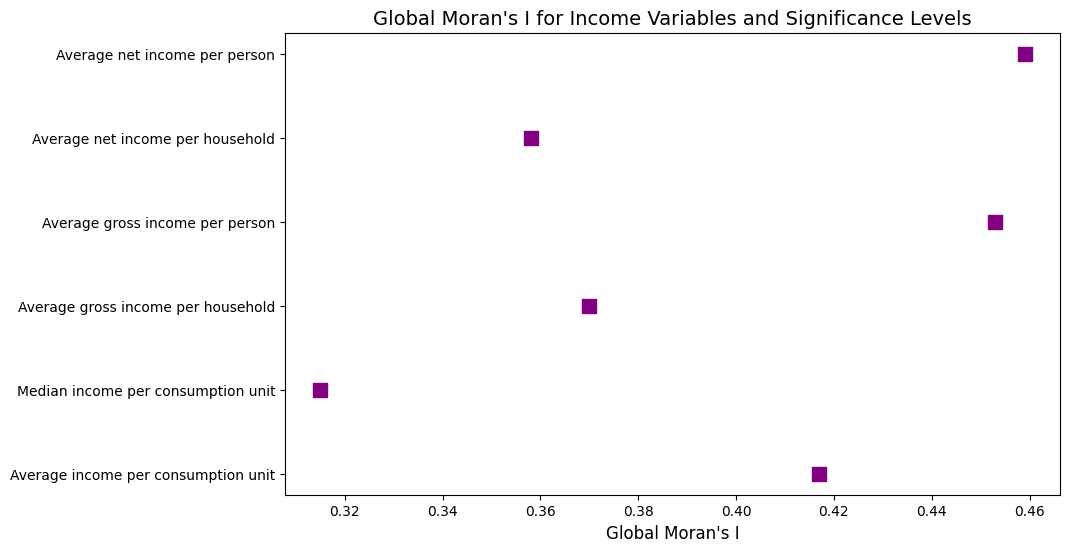

In [16]:
colors = ['purple' if p < 0.05 else 'black' for p in p_values]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(morans_I, variables, color=colors, s=100,  marker='s')  # s sets the size of the dots

# Set labels and title
plt.xlabel('Global Moran\'s I', fontsize=12)
plt.title('Global Moran\'s I for Income Variables and Significance Levels', fontsize=14)


# Customizing the y-axis labels (income variables)
plt.yticks(range(len(variables)), variables, fontsize=10)

if cfg.SAVE_FIGURES:
    plt.savefig(cfg.FIGURES_PATH / 'global_morans_significance.png', dpi=300, bbox_inches='tight')

## Income data

In [13]:
merged = gpd.read_file(cfg.INCOME_DATA / 'geometries_and_income.geojson') 

In [14]:
merged['Average income per consumption unit'].describe()

count       21.000000
mean     27070.333333
std       8453.982921
min      16116.000000
25%      20469.000000
50%      24874.000000
75%      32322.000000
max      43930.000000
Name: Average income per consumption unit, dtype: float64

In [15]:
merged.dtypes

Gini Index                              float64
ID                                        int32
Average income per consumption unit       int32
Median income per consumption unit        int32
Average gross income per household        int32
Average gross income per person           int32
Average net income per household          int32
Average net income per person             int32
geometry                               geometry
dtype: object

In [16]:
income_stats = merged.describe()
income_stats_big = income_stats.drop(columns=['ID', 'Gini Index'])
income_stats_small = income_stats[['Gini Index']]
income_stats_big = income_stats_big.round(3)
income_stats_small = income_stats_small.round(3)

if cfg.SAVE_DATASETS:
    income_stats_big.to_csv(cfg.DATASETS_PATH / 'income_stats.csv', index=True)
    income_stats_small.to_csv(cfg.DATASETS_PATH / 'gini_stats.csv', index=True)

In [17]:
income_stats_big

,Average income per consumption unit,Median income per consumption unit,Average gross income per household,Average gross income per person,Average net income per household,Average net income per person
count,21.000,21.000,21.000,21.000,21.000,21.000
mean,27070.333,22350.000,57604.857,23275.381,44733.381,18045.048
std,8453.983,5829.666,18974.136,8209.685,12225.614,5363.163
min,16116.000,14350.000,33395.000,12678.000,28681.000,10797.000
25%,20469.000,18550.000,42779.000,16498.000,35278.000,13719.000
50%,24874.000,19950.000,50487.000,21495.000,39991.000,17026.000
75%,32322.000,26950.000,72362.000,27311.000,55125.000,20671.000
max,43930.000,32550.000,97093.000,39346.000,69670.000,28233.000


In [18]:
income_stats_big = income_stats_big.drop(index='count')
income_stats_big = income_stats_big.reset_index().rename(columns={'index': 'Statistic'})

income_stats_small = income_stats_small.drop(index='count')
income_stats_small = income_stats_small.reset_index().rename(columns={'index': 'Statistic'})

In [19]:
income_stats_big

,Statistic,Average income per consumption unit,Median income per consumption unit,Average gross income per household,Average gross income per person,Average net income per household,Average net income per person
0,mean,27070.333,22350.000,57604.857,23275.381,44733.381,18045.048
1,std,8453.983,5829.666,18974.136,8209.685,12225.614,5363.163
2,min,16116.000,14350.000,33395.000,12678.000,28681.000,10797.000
3,25%,20469.000,18550.000,42779.000,16498.000,35278.000,13719.000
4,50%,24874.000,19950.000,50487.000,21495.000,39991.000,17026.000
5,75%,32322.000,26950.000,72362.000,27311.000,55125.000,20671.000
6,max,43930.000,32550.000,97093.000,39346.000,69670.000,28233.000


In [20]:
income_stats_big = income_stats_big.melt(id_vars='Statistic', var_name='Income Category', value_name='Value')

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_80891/101947411.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Income Category', y='Value', data=income_stats_big, palette='Set3')


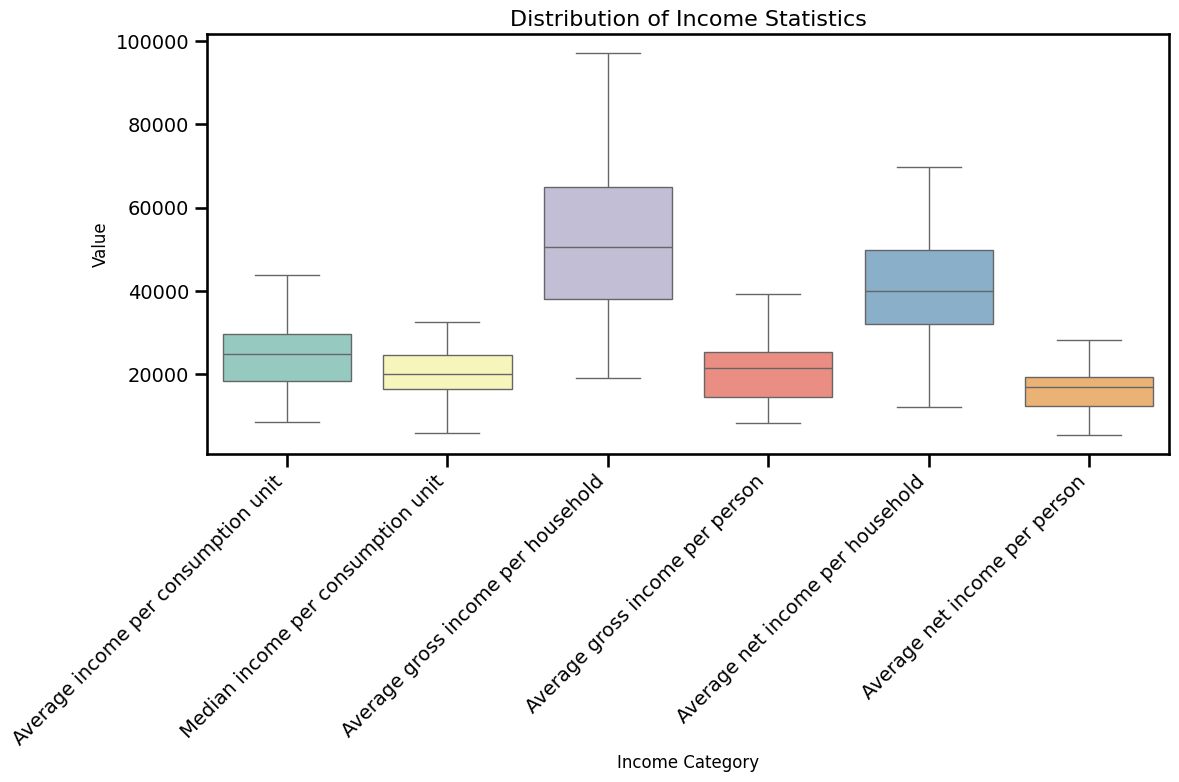

In [28]:
# Plotting the violin plot
plt.figure(figsize=(12, 8))

sns.boxplot(x='Income Category', y='Value', data=income_stats_big, palette='Set3')

plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)  # Increase the font size of y-tick labels
plt.title('Distribution of Income Statistics', fontsize=16)  # Increase the font size of the title
plt.xlabel('Income Category', fontsize=12)  # Increase font size for x-axis label
plt.ylabel('Value', fontsize=12)  # Increase font size for y-axis label
plt.tight_layout()

if cfg.SAVE_FIGURES:
    plt.savefig(cfg.FIGURES_PATH / 'income_statistics_boxplot.png', dpi=300, bbox_inches='tight')

## Trips

In [31]:
all_viajes.shape

(19900955, 15)

In [32]:
filtered_viajes.shape

(4839108, 15)

In [40]:
normalized_trip_counts = pd.read_csv('/Users/caro/Desktop/thesis_project/trip_analysis/FINAL_normalized_trip_count.csv')

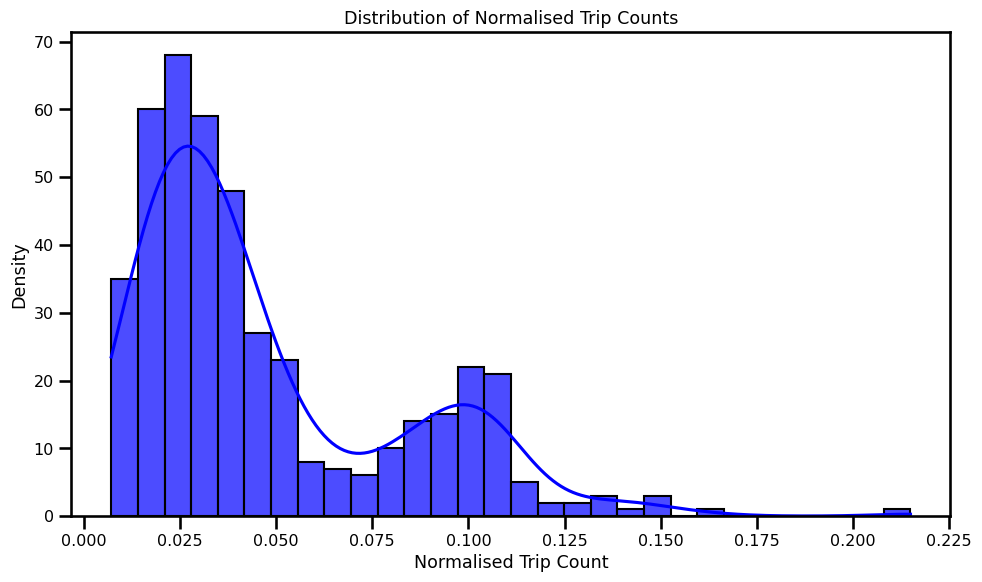

In [45]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Plotting the distribution using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(normalized_trip_counts['normalized_trip_count'], bins=30, kde=True, color='blue', alpha=0.7)
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.title('Distribution of Normalised Trip Counts')
plt.xlabel('Normalised Trip Count')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig(cfg.FIGURES_PATH / 'normalized_trip_count_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
normalized_trip_counts.describe()

,origen,destino,trip_count,normalized_trip_count
count,4.410000e+02,4.410000e+02,441.000000,441.000000
mean,2.807911e+06,2.807911e+06,10973.034014,0.047619
std,6.062178e+00,6.062178e+00,7798.083942,0.034239
min,2.807901e+06,2.807901e+06,969.000000,0.007166
25%,2.807906e+06,2.807906e+06,5110.000000,0.023132
50%,2.807911e+06,2.807911e+06,8315.000000,0.034781
75%,2.807916e+06,2.807916e+06,16414.000000,0.065337
max,2.807921e+06,2.807921e+06,36658.000000,0.214923


In [15]:
filtered_viajes['origen'].value_counts()

origen
2807913    327165
2807915    291898
2807911    279312
2807910    272315
2807920    265549
2807908    251018
2807916    231163
2807912    230787
2807902    230714
2807918    230571
2807901    229064
2807909    222036
2807917    218299
2807906    212322
2807914    211830
2807905    205081
2807903    202659
2807919    200911
2807904    200808
2807907    194238
2807921    131368
Name: count, dtype: int64

In [16]:
filtered_viajes['destino'].value_counts()

destino
2807901    314497
2807904    294641
2807907    286760
2807905    282802
2807908    279935
2807909    271858
2807915    257026
2807903    241772
2807916    240942
2807920    232022
2807913    231677
2807902    231099
2807906    228846
2807911    209789
2807912    190129
2807918    186369
2807910    180527
2807921    178309
2807919    173072
2807914    169536
2807917    157500
Name: count, dtype: int64

In [22]:
filtered_viajes['renta'].value_counts()

renta
>15      2814199
10-15    2024909
Name: count, dtype: int64

In [18]:
filtered_viajes['edad'].value_counts()

edad
45-65     1538593
25-45     1413815
65-100     980559
0-25       906141
Name: count, dtype: int64

In [19]:
filtered_viajes['sexo'].value_counts()

sexo
hombre    2505401
mujer     2333707
Name: count, dtype: int64

In [20]:
filtered_viajes['actividad_origen'].value_counts()

actividad_origen
casa    4839108
Name: count, dtype: int64

In [21]:
filtered_viajes['actividad_destino'].value_counts()

actividad_destino
frecuente          2148791
no_frecuente       1484577
trabajo_estudio    1205740
Name: count, dtype: int64

In [23]:
filtered_viajes['distancia'].value_counts()

distancia
2-10     2763117
0.5-2    1478457
10-50     597534
Name: count, dtype: int64